In [78]:
from RandomForest import RandomForest
from DecisionTree import DecisionTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

np.random.seed(42)
random.seed(42)

In [79]:
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [80]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)


In [81]:
max_depth = 3

classifier = DecisionTree(max_depth=max_depth)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Confusion matrix: \n{classifier.confusion_matrix(y_test, y_pred)}")
accuracy, precision, recall, f1 = classifier.metrics(classifier.confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


Confusion matrix: 
[[39 16]
 [16 83]]
Accuracy: 0.7922077922077922
Precision: 0.7090909090909091
Recall: 0.7090909090909091
F1: 0.7090909090909091


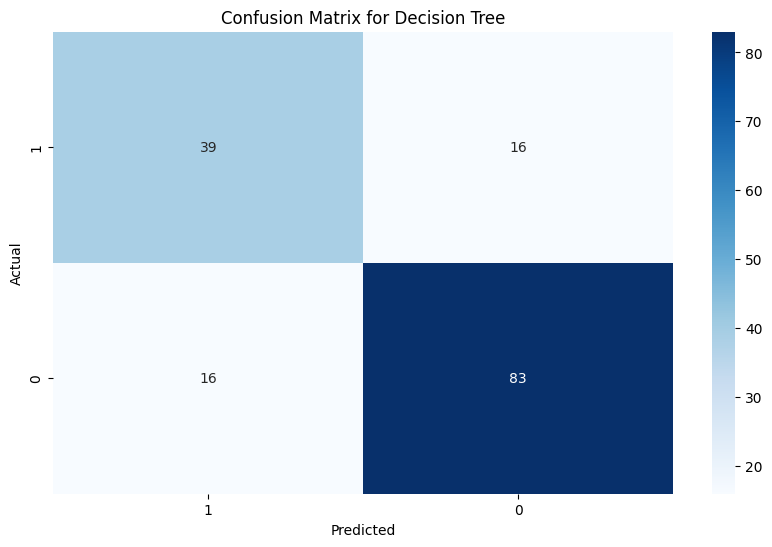

In [82]:
plt.figure(figsize=(10,6))
confusion_matrix = classifier.confusion_matrix(y_test, y_pred)
confusion_matrix[0][0], confusion_matrix[1][1] = confusion_matrix[1][1], confusion_matrix[0][0]
confusion_matrix[0][1], confusion_matrix[1][0] = confusion_matrix[1][0], confusion_matrix[0][1]
sns.heatmap(confusion_matrix, annot=True ,fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()


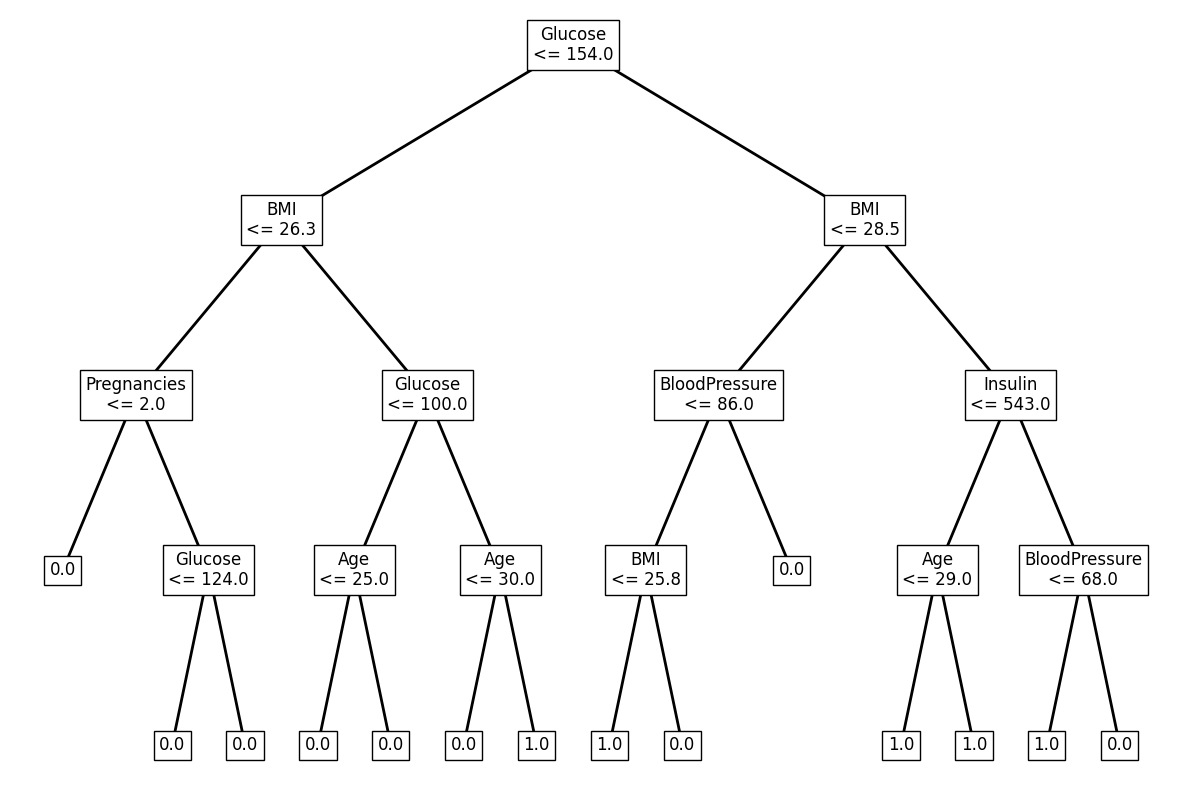

In [83]:
from plot_tree import plot_tree
feature_names = data.columns[:-1]

plt.figure(figsize=(15, 10))
plot_tree(classifier.root, feature_names, max_depth=max_depth)
plt.axis('off')
plt.show()

In [84]:
classifier2 = RandomForest(25, max_depth=3)
classifier2.fit(X_train, y_train)
y_pred = classifier2.predict(X_test)
print(f"Confusion matrix: \n{classifier.confusion_matrix(y_test, y_pred)}")
accuracy, precision, recall, f1 = classifier.metrics(classifier.confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


Confusion matrix: 
[[28  8]
 [27 91]]
Accuracy: 0.7727272727272727
Precision: 0.7777777777777778
Recall: 0.509090909090909
F1: 0.6153846153846153


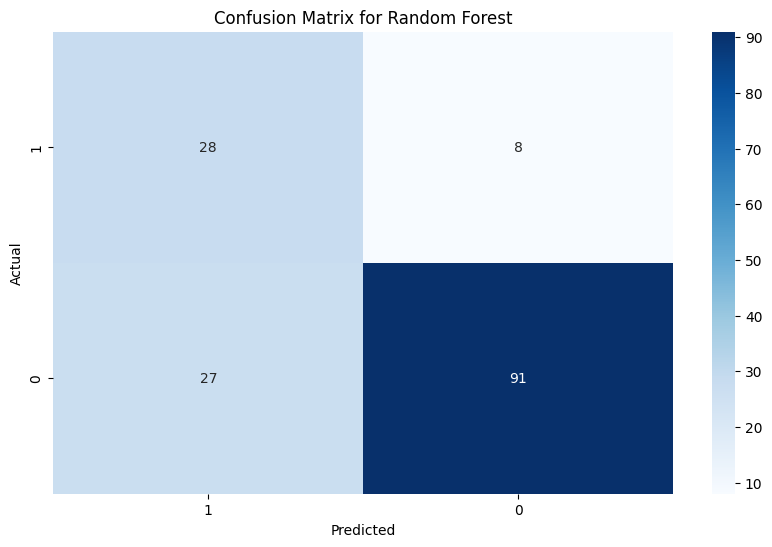

In [85]:

plt.figure(figsize=(10,6))
confusion_matrix = classifier.confusion_matrix(y_test, y_pred)
confusion_matrix[0][0], confusion_matrix[1][1] = confusion_matrix[1][1], confusion_matrix[0][0]
confusion_matrix[0][1], confusion_matrix[1][0] = confusion_matrix[1][0], confusion_matrix[0][1]
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()


